# Navigation

---

Hi! this repo is about the udacity navigation project where we will learn an agent to go around and get some bananas. more speicifically the yellow bananas, while the blue one must be avoided!

if you want to follow along the first thing you need to do is setup the enviroment by following [this instructions](./Setup.ipynb)

![collector](start.gif)

I will try to first resolve the enviroment as simple as possible, then introduce some advance techinics to see them in actions.

###### imports

In [8]:
import numpy as np
from unityagents import UnityEnvironment
import random
import torch
from collections import defaultdict, namedtuple,deque
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("we will use ", device)

we will use  cuda:0


# UnityEnvironment
we load the enviroment. the enviroment contains only 1 brain

In [12]:
env = UnityEnvironment(file_name="Banana.exe")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [13]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# State

the state represents 7 rays going out from the agents coded in 5 dimension. the first 4 is what the ray hit (yellow banana, blue banana, wall, nothing) and followed by the distance of the hit object.
the last 2 number represent the speed of the agent. 

![state](img_banana_env_observations.png)

---

our state is 7 rays * (4 class dimensions, 1 distance dimention) + 2 speed  => 7* 5 + 2 => 37 dimensions state

# Actions

The avalible actions are 4:

- Action 0: Move forward.
- Action 1: Move backward.
- Action 2: Turn left.
- Action 3: Turn right.

![action](img_banana_env_actions.png)

# Vanilla DQN

the enviroments looks really simple so let's try with the simpler DQN network I can up with, ie only one hidden layer.
the hidden layer shall have a dimension beetween the state and the action dimesion, and since I want the simpler let's say 8.

In [14]:
class VanillaQNetwork(nn.Module):
    

    def __init__(self, state_size, action_size, units=8):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            units (int): Hidden layer dimension
        """
        super(VanillaQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, units)
        self.fc2 = nn.Linear(units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return x


# Agent
if we ingnore all last 6 years of new techinics that's how the agent will look like.
the agent will learn from each experience, no buffer, no target, nothing, just simple eval of the tuples: state, action, reward, next state.
![dockey](dockey.jpg)
will be our dockey agent able to learn walk straight in such condition?

In [15]:
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate

class VanillaAgent():

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork = VanillaQNetwork(
            state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=LR)

    def step(self, state, action, reward, next_state):

        states = torch.from_numpy(
            np.vstack([state])).float().to(device)
        actions = torch.from_numpy(
            np.vstack([action])).long().to(device)
        rewards = torch.from_numpy(
            np.vstack([reward])).float().to(device)
        next_states = torch.from_numpy(
            np.vstack([next_state])).float().to(device)

        self.learn(states, actions, rewards, next_states)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.qnetwork.eval()
            with torch.no_grad():
                action_values = self.qnetwork(state)
            self.qnetwork.train()
            return np.argmax(action_values.cpu().data.numpy()).astype(int)
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, states, actions, rewards, next_states):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s') tuples 
        """
        # Get max predicted Q values (for next states)
        Q_targets_next = self.qnetwork(
            next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (GAMMA * Q_targets_next)

        # Get expected Q values from local model
        Q_expected = self.qnetwork(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def load(self, file_name):
        if file_name is None:
            return
        self.qnetwork.load_state_dict(torch.load(file_name))

    def save(self, file_name):
        if file_name is None:
            return
        torch.save(self.qnetwork.state_dict(), file_name)


# Training Function
next we define our tranning function, I would like to have a tranning function which take a any agent and train it. I also would like to save the result and be able to load it back for some more trainning.
As this Enviroment is a continuos task (pick yellow bananas avoid blue bananas) I will completly ingnore the eperiences at the end of the episodes. that would be different if the enviroment was about complete a task.
the tranning function need a agent and a function to trasform the env_info to the agent input state

In [16]:
def dqn(agent, state_transform=lambda state: state, file_start=None, file_success=None, file_end=None, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,):
    """Deep Q-Learning.

    Params
    ======
        state_transform f(env_info): function to transform env_info to agent state input
        file_start: file to load the agent
        file_end: file to store the agent at the end of training
        file_success: file to store the agent when env is resolved
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    agent.load(file_start)             # load agent

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = state_transform(env_info)
        score = 0
        done = False
        while not done:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = state_transform(
                env_info), env_info.rewards[0], env_info.local_done[0]
            if not done:
                agent.step(state, action, reward, next_state)
            state = next_state
            score += reward
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        message = '\rEpisode {}\tAverage Score: {:.2f}\teps: {:.2f}'.format(
            i_episode, np.mean(scores_window), eps)
        eps = max(eps_end, eps_decay*eps)  # decrease epsilon
        print(message, end="")
        if i_episode % 100 == 0:
            print(message)
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode-100, np.mean(scores_window)))
            agent.save(file_success)
            break
    agent.save(file_end)
    return scores

In [9]:
# transform for Vanilla agent
def state_transform(env_info):
    return env_info.vector_observations[0]
# instance Agent
agent = VanillaAgent(state_size=state_size, action_size=action_size)

# trainning
scores = dqn(agent, state_transform=state_transform,
             file_start=None, file_end='vanilla_model_2000_episodes.pth', file_success='vanilla_model_success.pth')


Episode 100	Average Score: -0.23	eps: 0.61
Episode 200	Average Score: 0.99	eps: 0.379
Episode 300	Average Score: 3.78	eps: 0.22
Episode 400	Average Score: 6.85	eps: 0.14
Episode 500	Average Score: 8.27	eps: 0.08
Episode 600	Average Score: 8.98	eps: 0.05
Episode 700	Average Score: 10.01	eps: 0.03
Episode 800	Average Score: 10.61	eps: 0.02
Episode 900	Average Score: 11.04	eps: 0.01
Episode 1000	Average Score: 11.45	eps: 0.01
Episode 1100	Average Score: 11.12	eps: 0.01
Episode 1200	Average Score: 11.35	eps: 0.01
Episode 1300	Average Score: 11.01	eps: 0.01
Episode 1400	Average Score: 11.57	eps: 0.01
Episode 1500	Average Score: 10.47	eps: 0.01
Episode 1600	Average Score: 11.98	eps: 0.01
Episode 1700	Average Score: 11.39	eps: 0.01
Episode 1800	Average Score: 10.88	eps: 0.01
Episode 1900	Average Score: 11.50	eps: 0.01
Episode 2000	Average Score: 11.32	eps: 0.01


# Vanilla agent scores
Our Vanilla agent did learn but not enought, after 2K episoded it reached 11.32 points avarage.
let's give a look on its learning curve by plotting the scores.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

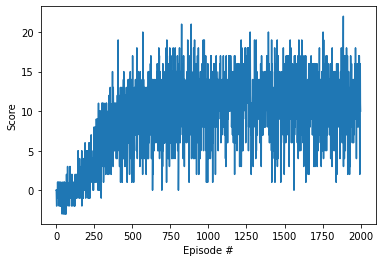

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

As we can see: \
The tranning is super unstable, it did score more that 20 points but never the less it was not able to learn regulary. \
2000 episodeds where not enought to solve the enviroment. \
We see that he actually came close to it. \
\
This suggest me that we do not need a much more complex neural network, we need a better tranning techinics.

# Replay Buffer
the first thing I would like to do is to add e simple replay buffer, ie the agent will keep its experiences while executing episodes and when asked to learn it will also sample from its past experiences.

In [21]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=[
                                     "state", "action", "reward", "next_state"])

    def add(self, state, action, reward, next_state):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        if len(self) <= self.batch_size:
            experiences = self.memory
        else:
            experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(
            np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack(
            [e.next_state for e in experiences if e is not None])).float().to(device)

        return (states, actions, rewards, next_states)

    def __len__(self):
        return len(self.memory)

# Vanilla with replay buffer agent
now we create a better agent with a replay buffer

In [22]:
class VanillaWithReplayBufferAgent():

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.replay_buffer = ReplayBuffer(int(1e5), 64)

        # Q-Network
        self.qnetwork = VanillaQNetwork(
            state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=LR)

    def step(self, state, action, reward, next_state):

        self.replay_buffer.add(state, action, reward, next_state)
        states, actions, rewards, next_states = self.replay_buffer.sample()
        self.learn(states, actions, rewards, next_states)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.qnetwork.eval()
            with torch.no_grad():
                action_values = self.qnetwork(state)
            self.qnetwork.train()
            return np.argmax(action_values.cpu().data.numpy()).astype(int)
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, states, actions, rewards, next_states):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s') tuples 
        """
        # Get max predicted Q values (for next states)
        Q_targets_next = self.qnetwork(
            next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (GAMMA * Q_targets_next)

        # Get expected Q values from local model
        Q_expected = self.qnetwork(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def load(self, file_name):
        if file_name is None:
            return
        self.qnetwork.load_state_dict(torch.load(file_name))

    def save(self, file_name):
        if file_name is None:
            return
        torch.save(self.qnetwork.state_dict(), file_name)

In [23]:
# transform for Vanilla agent
def state_transform(env_info):
    return env_info.vector_observations[0]
# instance Agent
agent = VanillaWithReplayBufferAgent(state_size=state_size, action_size=action_size)

# trainning
scores = dqn(agent, state_transform=state_transform,
             file_start=None, file_end='vanilla_memory_model_2000_episodes.pth', 
             file_success='vanilla_memory_model_success.pth')

Episode 100	Average Score: 1.11	eps: 0.61
Episode 200	Average Score: 4.07	eps: 0.37
Episode 300	Average Score: 6.91	eps: 0.22
Episode 400	Average Score: 7.81	eps: 0.14
Episode 500	Average Score: 8.55	eps: 0.08
Episode 600	Average Score: 9.84	eps: 0.05
Episode 700	Average Score: 11.48	eps: 0.03
Episode 800	Average Score: 11.57	eps: 0.02
Episode 900	Average Score: 12.67	eps: 0.01
Episode 914	Average Score: 13.09	eps: 0.01
Environment solved in 814 episodes!	Average Score: 13.09


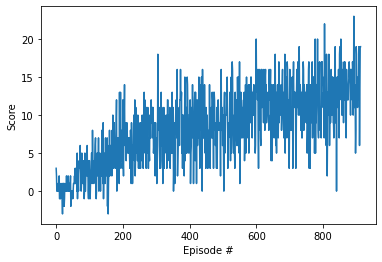

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

with the memory buffer our Vanilla agent was able to solve the enviroment in 814 episodes. \
this confirm me than the NN is enought for it. \
the trainning is much faster as the agent takes in account also 63 old experience each time it gain one, but indeed still quite unstable.

# Dueling Neural Networks

I did enjoy the first 2 season of WestWorld, showing this idea of a dual chamber AI brain like our own.
let's upgrade out agent to have 2 neural network trainning one other. \
\
We seen during the lections than we do not actually need 2 NN, we can a snapshot the network and use it as reference to train its self and then update the snapshoot. \
\
I will instead stick to 2 separated network and I will randomatically decide which one train and which one is used as reference. 

In [32]:
class DuelingAgent():

    def __init__(self, state_size, action_size,replay_buffer):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.replay_buffer = replay_buffer

        # Q-Network
        self.left_lobe = VanillaQNetwork(
            state_size, action_size).to(device)
        self.right_lobe = VanillaQNetwork(
            state_size, action_size).to(device)
        self.left_optimizer = optim.Adam(self.left_lobe.parameters(), lr=LR)
        self.right_optimizer = optim.Adam(self.right_lobe.parameters(), lr=LR)

    def step(self, state, action, reward, next_state):

        self.replay_buffer.add(state, action, reward, next_state)
        states, actions, rewards, next_states = self.replay_buffer.sample()
        self.learn(states, actions, rewards, next_states)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            n = self.left_lobe if random.random() < 0.5 else self.right_lobe
            n.eval()
            with torch.no_grad():
                action_values = n(state)
            n.train()
            return np.argmax(action_values.cpu().data.numpy()).astype(int)
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, states, actions, rewards, next_states):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s') tuples 
        """
        if random.random() < 0.5:
            training_network, reference_network, optimizer = self.left_lobe, self.right_lobe, self.left_optimizer
        else:
            training_network, reference_network, optimizer = self.right_lobe, self.left_lobe, self.right_optimizer

        # Get max predicted Q values (for next states)
        Q_targets_next = reference_network(
            next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (GAMMA * Q_targets_next)

        # Get expected Q values from local model
        Q_expected = training_network(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def load(self, file_name):
        if file_name is None:
            return
        lobes = torch.load(file_name)
        self.left_lobe.load_state_dict(lobes[0])
        self.right_lobe.load_state_dict(lobes[1])

    def save(self, file_name):
        if file_name is None:
            return
        torch.save([self.left_lobe.state_dict(),
                   self.right_lobe.state_dict()], file_name)


In [29]:
# instance Agent
agent = DuelingAgent(state_size=state_size, action_size=action_size,replay_buffer = ReplayBuffer(int(1e5), 64))

# trainning
scores = dqn(agent, state_transform=state_transform,
             file_start=None, file_end='dueling_2000_episodes.pth', 
             file_success='dueling_success.pth')

Episode 100	Average Score: 0.79	eps: 0.61
Episode 200	Average Score: 4.56	eps: 0.37
Episode 300	Average Score: 6.66	eps: 0.22
Episode 400	Average Score: 7.94	eps: 0.14
Episode 500	Average Score: 9.30	eps: 0.08
Episode 600	Average Score: 9.43	eps: 0.05
Episode 700	Average Score: 11.04	eps: 0.03
Episode 800	Average Score: 11.56	eps: 0.02
Episode 900	Average Score: 12.39	eps: 0.01
Episode 1000	Average Score: 12.11	eps: 0.01
Episode 1100	Average Score: 12.25	eps: 0.01
Episode 1200	Average Score: 11.78	eps: 0.01
Episode 1300	Average Score: 12.50	eps: 0.01
Episode 1400	Average Score: 11.89	eps: 0.01
Episode 1500	Average Score: 11.59	eps: 0.01
Episode 1600	Average Score: 11.41	eps: 0.01
Episode 1700	Average Score: 12.10	eps: 0.01
Episode 1800	Average Score: 12.31	eps: 0.01
Episode 1900	Average Score: 11.24	eps: 0.01
Episode 2000	Average Score: 11.59	eps: 0.01


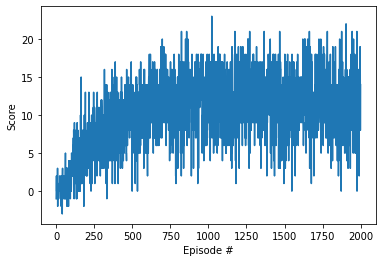

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Well, that is quite disappoting, like season 3. \
it looks to me after 1k episodes the agent wasn't learning much. \
I could try with a self dueling network, but I know that works, I want to try something else.

In [10]:
env.close()

In [18]:
1e5

100000.0

In [30]:
torch.save(scores, "scores_dueling.pth")